# **5. Optimizing a Neural Network**

In [1]:
import math
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F

## **Load the dataset (optional)**
---

- We load the CIFAR10 dataset
- For educational purposes, the CIFAR10 images would be
    - Greyscaled, from RGB to grayscale
    - Downsized, from 32x32 to 20x20
    - Downsampled, from 50,000 training images to 30,000 training images

In [2]:
# Import library to load CIFAR10
from keras.datasets import cifar10
import cv2

2024-12-08 15:32:46.995976: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733671967.014353    6673 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733671967.020114    6673 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-08 15:32:47.039679: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# Load train & test data
# We use only train data
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 19s 0us/step


In [4]:
# Shape of training data
X_train.shape

# (n_data, height_size, width_size, color channel)

(50000, 32, 32, 3)

In [5]:
# This is the data labels
labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

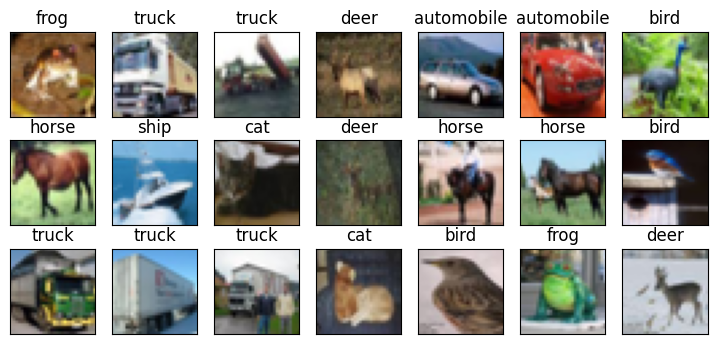

In [6]:
# Plot several sample
fig, axes = plt.subplots(ncols=7, nrows=3, figsize=(9, 4))
index = 0
for i in range(3):
    for j in range(7):
        axes[i,j].set_title(labels[y_train[index][0]], size=12)
        axes[i,j].imshow(X_train[index])
        axes[i,j].get_xaxis().set_visible(False)
        axes[i,j].get_yaxis().set_visible(False)
        index += 1
plt.show()

Now, we greyscale the images

In [7]:
# Grayscale the images
X_train = np.array([cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) for image in X_train])

In [8]:
# Reshape the y_train
y_train = np.array([i[0] for i in y_train])

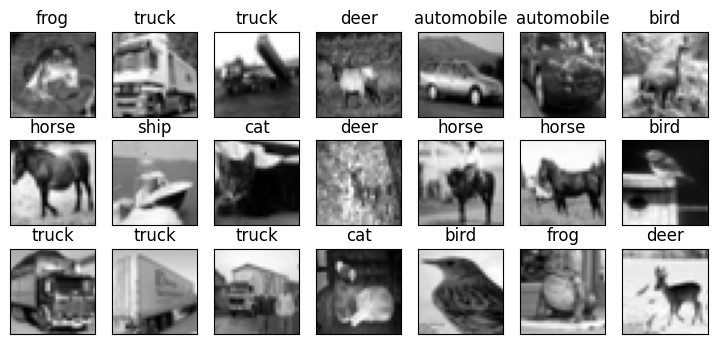

In [9]:
# Plot samples
fig, axes = plt.subplots(ncols=7, nrows=3, figsize=(9, 4))
index = 0
for i in range(3):
    for j in range(7):
        axes[i,j].set_title(labels[y_train[index]], size=12)
        axes[i,j].imshow(X_train[index], cmap='gray')
        axes[i,j].get_xaxis().set_visible(False)
        axes[i,j].get_yaxis().set_visible(False)
        index += 1
plt.show()

In [10]:
# New training data shape
X_train.shape

# (n_data, height_size, width_size)

(50000, 32, 32)

Next, we downsample the data from 50,000 to 30,000

In [11]:
# Resample data
from sklearn.model_selection import train_test_split

In [12]:
X_downsample, _, y_downsample, _ = train_test_split(X_train, y_train,
                                                    stratify = y_train,
                                                    test_size = 0.4,
                                                    random_state = 123)

X_downsample.shape, y_downsample.shape

((30000, 32, 32), (30000,))

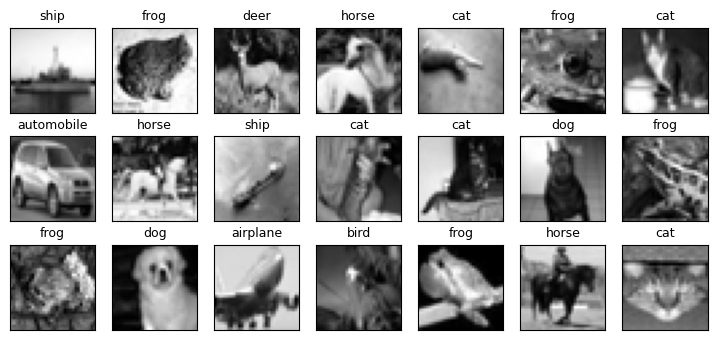

In [13]:
# Plot samples
fig, axes = plt.subplots(ncols=7, nrows=3, figsize=(9, 4))
index = 0
for i in range(3):
    for j in range(7):
        axes[i,j].set_title(labels[y_downsample[index]], size=9)
        axes[i,j].imshow(X_downsample[index], cmap='gray')
        axes[i,j].get_xaxis().set_visible(False)
        axes[i,j].get_yaxis().set_visible(False)
        index += 1
plt.show()

In [14]:
# Save the downsampled data
X_downsample_ = []
for data in X_downsample:
    # Convert data
    data = data.reshape(-1)

    X_downsample_.append(data)

X_downsample_ = np.array(X_downsample_)
X_downsample_.shape

(30000, 1024)

Finally we downsize the data, from 32x32 to 20x20

In [17]:
# use this library
from skimage.transform import resize

In [18]:
# Initialize
n_init = 32
n_size = 20
X_downscaled = np.zeros((X_downsample_.shape[0], n_size*n_size))

# Iterate
for i, img in enumerate(X_downsample_):
    # Resize image
    img = img.reshape((n_init, n_init))
    img_new = resize(img, (n_size, n_size), anti_aliasing=True).reshape(-1)

    # Append
    X_downscaled[i] = img_new

# Validate
print('X final shape:', X_downscaled.shape)

X final shape: (30000, 400)


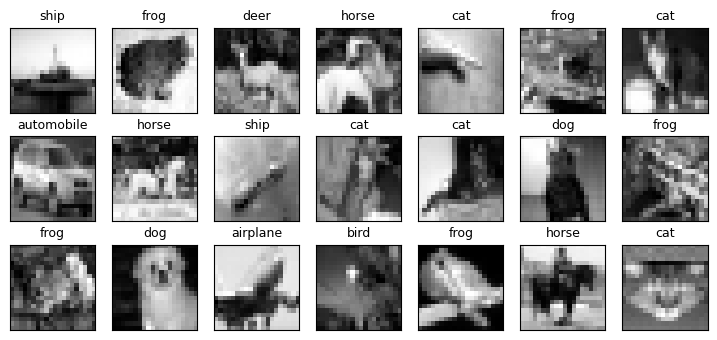

In [19]:
fig, axes = plt.subplots(ncols=7, nrows=3, figsize=(9, 4))
index = 0
for i in range(3):
    for j in range(7):
        axes[i,j].set_title(labels[y_downsample[index]], size=9)
        axes[i,j].imshow(X_downscaled[index].reshape((n_size, n_size)), cmap='gray')
        axes[i,j].get_xaxis().set_visible(False)
        axes[i,j].get_yaxis().set_visible(False)
        index += 1
plt.show()

Lastly, we save the final data as our train data

In [20]:
# Concat data
concated_data = np.column_stack((y_downsample, X_downscaled))
concated_data

array([[8.        , 0.80563061, 0.81186105, ..., 0.4392007 , 0.44417329,
        0.46927089],
       [6.        , 0.75925354, 0.8300434 , ..., 0.95191812, 0.93912283,
        0.96205842],
       [4.        , 0.23600153, 0.23444309, ..., 0.33025025, 0.31814988,
        0.46329593],
       ...,
       [7.        , 0.98780654, 0.98165495, ..., 0.75295249, 0.77390492,
        0.76486329],
       [3.        , 0.3632106 , 0.40124783, ..., 0.29658808, 0.17469434,
        0.15571276],
       [4.        , 0.16311142, 0.17223067, ..., 0.40143046, 0.53336938,
        0.31814908]])

In [21]:
concated_df = pd.DataFrame(concated_data)
concated_df

,0,1,2,3,4,5,6,7,8,9,...,391,392,393,394,395,396,397,398,399,400
0,8.0,0.805631,0.811861,0.825589,0.836545,0.842840,0.853010,0.859282,0.864211,0.871722,...,0.237289,0.200400,0.203675,0.228150,0.361053,0.432430,0.429654,0.439201,0.444173,0.469271
1,6.0,0.759254,0.830043,0.810526,0.832540,0.842396,0.869095,0.871501,0.846366,0.796811,...,0.914859,0.966332,0.964715,0.967834,0.976408,0.966763,0.974604,0.951918,0.939123,0.962058
2,4.0,0.236002,0.234443,0.249684,0.255348,0.291446,0.235633,0.236962,0.260447,0.222175,...,0.503984,0.439816,0.478677,0.651968,0.582789,0.459420,0.406756,0.330250,0.318150,0.463296
3,7.0,0.118592,0.209883,0.233603,0.241030,0.148941,0.098644,0.115421,0.091965,0.116822,...,0.163633,0.162113,0.620229,0.491155,0.209512,0.210420,0.272527,0.601884,0.478388,0.453376
4,3.0,0.684794,0.738589,0.790243,0.787739,0.745771,0.737059,0.736237,0.737507,0.731771,...,0.632699,0.645396,0.629260,0.592279,0.616714,0.611665,0.589879,0.576828,0.533161,0.510313
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,4.0,0.367131,0.419208,0.415222,0.447276,0.492776,0.450341,0.457371,0.442957,0.445363,...,0.307979,0.317076,0.488895,0.582731,0.544254,0.472435,0.434448,0.420998,0.405589,0.381749
29996,3.0,0.402912,0.361167,0.373472,0.351431,0.366431,0.404601,0.433375,0.463346,0.466803,...,0.257514,0.263044,0.402864,0.613476,0.642621,0.737585,0.547641,0.443589,0.411131,0.418333
29997,7.0,0.987807,0.981655,0.975792,0.980006,0.983478,0.986899,0.988784,0.990082,0.990185,...,0.724872,0.702611,0.727313,0.738673,0.729338,0.727340,0.730700,0.752952,0.773905,0.764863
29998,3.0,0.363211,0.401248,0.431374,0.468596,0.499982,0.529334,0.552846,0.583522,0.607195,...,0.471659,0.475721,0.455957,0.439185,0.429897,0.390734,0.364313,0.296588,0.174694,0.155713


In [22]:
# Save
concated_df.to_csv('CIFAR10_grey_ds.csv', index=False)

## **Task 1: Classify Images with MLP**
---

**Task brief:**
- This is a multiclass classification
- The input are several images with object
- We use a multilayer perceptron with 1 hidden layer (100 neurons) and 1 output layer (10 output neurons)

Load the data

- Data source: A downsampled CIFAR 10

In [23]:
def read_data(fname):
    """Read the data"""
    # Read data
    raw_data = pd.read_csv(fname)

    # Wrangle data
    y = raw_data['0'].to_numpy().astype('int64')
    X = raw_data.drop(columns=['0'], axis=1).to_numpy().astype('float64')

    # Validate
    print('Input shape  :', X.shape)
    print('Target shape :', y.shape)

    return X, y


In [24]:
# Read data
fname = 'CIFAR10_grey_ds.csv'
X, y = read_data(fname=fname)

Input shape  : (30000, 400)
Target shape : (30000,)


In [25]:
labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [26]:
# Initialize
n_size = 20     # Image size

Then we split the data

In [27]:
# Load library
from sklearn.model_selection import train_test_split

In [28]:
# Split 1: whole data to train (90%) & test (10%)
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.1,
                                                    random_state = 42)

# Split 2: test data to test (50%) & valid (50%)
X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test,
                                                    test_size = 0.5,
                                                    random_state = 42)

X_train.shape, X_valid.shape, X_test.shape

((27000, 400), (1500, 400), (1500, 400))

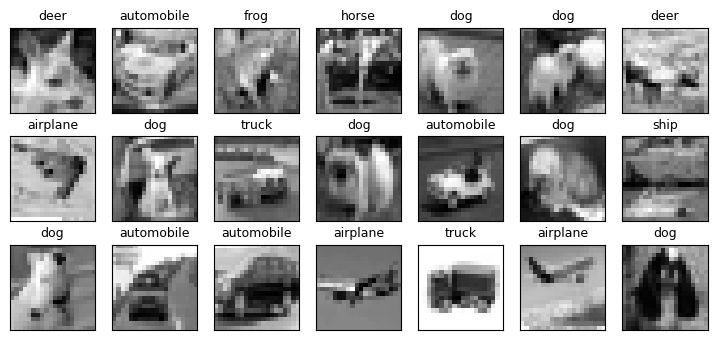

In [29]:
fig, axes = plt.subplots(ncols=7, nrows=3, figsize=(9, 4))
index = 0
for i in range(3):
    for j in range(7):
        axes[i,j].set_title(labels[y_train[index]], size=9)
        axes[i,j].imshow(X_train[index].reshape((n_size, n_size)), cmap='gray')
        axes[i,j].get_xaxis().set_visible(False)
        axes[i,j].get_yaxis().set_visible(False)
        index += 1
plt.show()

Convert `numpy` to `torch`

In [30]:
X_train = torch.tensor(X_train)
y_train = torch.tensor(y_train)
X_valid = torch.tensor(X_valid)
y_valid = torch.tensor(y_valid)
X_test = torch.tensor(X_test)
y_test = torch.tensor(y_test)

Now, build an end to end pipeline of the MLP

In [31]:
# Initialize some parameters
n_img = n_size*n_size   # input size
n_hidden = 100          # neuron size in the hidden layer
n_class = 10            # output size

# Initialize the MLP
g = torch.Generator().manual_seed(42)
W1 = torch.randn((n_img, n_hidden),     generator=g, dtype=torch.float64)
b1 = torch.randn(n_hidden,              generator=g, dtype=torch.float64)
W2 = torch.randn((n_hidden, n_class),   generator=g, dtype=torch.float64)
b2 = torch.randn(n_class,               generator=g, dtype=torch.float64)

# Collect the parameters
parameters = [W1, b1, W2, b2]
print('Total parameters :', sum(p.nelement() for p in parameters))

Total parameters : 41110


Next, we activate `requires_grad` for optimization

In [32]:
for p in parameters:
    p.requires_grad = True

Finally, we can start the training

In [33]:
# Initialize
max_steps = 200_000
batch_size = 32
losses = []

for i in range(max_steps):
    # First, construct the mini batch
    ix = torch.randint(low = 0,
                       high = X_train.shape[0],
                       size = (batch_size,),
                       generator = g)
    X_batch, y_batch = X_train[ix], y_train[ix]

    # Perform the forward pass
    h_pre_act = X_batch @ W1 + b1       # Hidden layer: pre-activated values
    h = torch.tanh(h_pre_act)           # Hidden layer: activated values with TanH
    logits = h @ W2 + b2                # Output layer: pre-activated values
    # Why logits not softmax of logits?

    # Calculate the loss
    loss = F.cross_entropy(input = logits,
                           target = y_batch)

    # Perform the backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # Update the parameters
    lr = 0.1 if i < 100_000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # Track
    if i % 10_000 == 0:
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")

    # Update progress in log
    losses.append(loss.log().item())


      0/ 200000: 10.0909
  10000/ 200000: 2.3033
  20000/ 200000: 2.0339
  30000/ 200000: 2.0258
  40000/ 200000: 2.0154
  50000/ 200000: 1.9654
  60000/ 200000: 2.2032
  70000/ 200000: 1.9388
  80000/ 200000: 2.0694
  90000/ 200000: 1.9249
 100000/ 200000: 1.5769
 110000/ 200000: 1.9866
 120000/ 200000: 2.0307
 130000/ 200000: 2.0527
 140000/ 200000: 1.6198
 150000/ 200000: 2.0652
 160000/ 200000: 1.7048
 170000/ 200000: 2.1214
 180000/ 200000: 1.7968
 190000/ 200000: 1.7088


Now, let's plot the losses

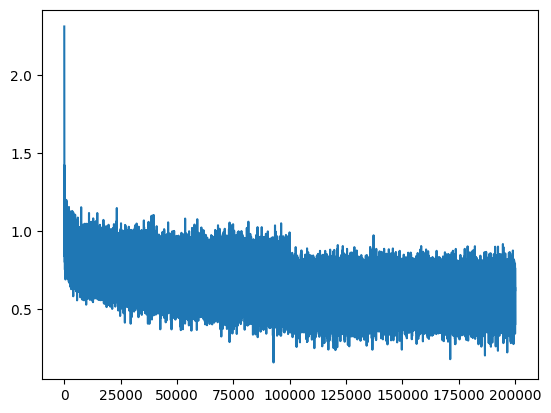

In [34]:
plt.plot(losses);

What do you think about the losses curve?
```
Comment here
```

Now, we can evaluate our model on `train` and `valid` dataset

In [35]:
@torch.no_grad()
def check_loss(type):
    """obtain loss on dataset"""
    X, y = {
        "train": (X_train, y_train),
        "valid": (X_valid, y_valid),
        "test": (X_test, y_test)
    }[type]

    # Perform the forward pass
    h_pre_act = X @ W1 + b1
    h = torch.tanh(h_pre_act)
    logits = h @ W2 + b2

    # Calculate loss
    loss = F.cross_entropy(input = logits,
                           target = y)

    print(f"{type}: {loss.item():.4f}")

In [36]:
check_loss("train")
check_loss("valid")
# Why not check_loss("test")?

train: 1.8172
valid: 1.9841


Get the samples of model

In [37]:
# Get random index from valid data
ix = torch.randint(low = 0,
                   high = X_valid.shape[0],
                   size = (21,),
                   generator = torch.Generator().manual_seed(42))

X_samples, y_samples = X_valid[ix], y_valid[ix]
y_samples

tensor([0, 9, 6, 0, 0, 6, 8, 4, 6, 9, 1, 4, 5, 8, 5, 3, 3, 6, 0, 5, 7])

In [38]:
# Get prediction
h_pre_act = X_samples @ W1 + b1
h = torch.tanh(h_pre_act)
logits = h @ W2 + b2
probs = F.softmax(logits, dim=1)
y_samples_pred = probs.argmax(axis=1)

y_samples_pred

tensor([2, 0, 4, 0, 8, 4, 8, 4, 3, 1, 1, 6, 3, 9, 5, 2, 4, 6, 0, 9, 0])

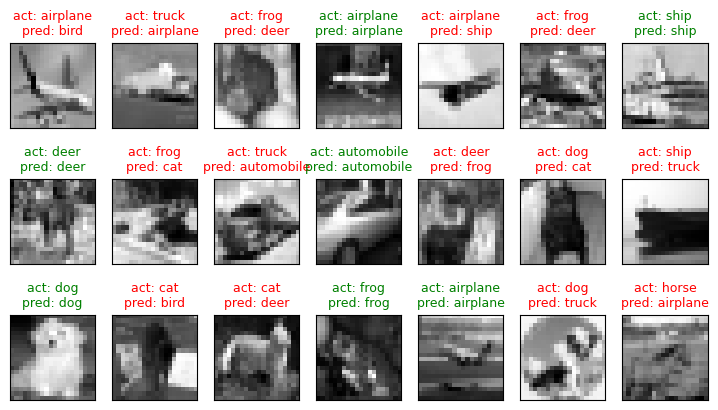

In [39]:
fig, axes = plt.subplots(ncols=7, nrows=3, figsize=(9, 5))
index = 0
for i in range(3):
    for j in range(7):
        act_label = labels[y_samples[index]]
        pred_label = labels[y_samples_pred[index]]
        if act_label==pred_label:
            color = 'g'
        else:
            color = 'r'
        axes[i,j].set_title(f'act: {act_label}\npred: {pred_label}', color=color, size=9)
        axes[i,j].imshow(X_samples[index].reshape((n_size, n_size)), cmap='gray')
        axes[i,j].get_xaxis().set_visible(False)
        axes[i,j].get_yaxis().set_visible(False)
        index += 1
plt.show()

## **Task 2: Fix the Initial Loss**
---

- The initial loss is too high

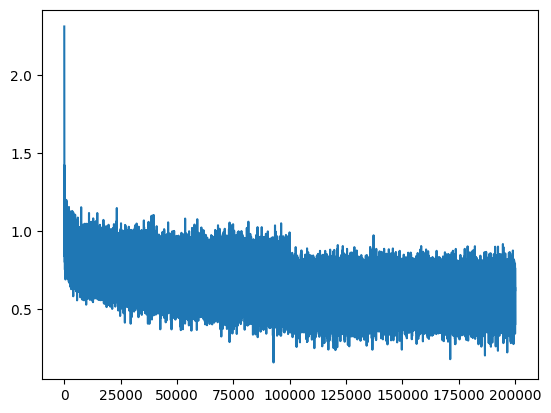

In [40]:
plt.plot(losses);

- We expect that on the untrained model, there is no class tendency
- **Then, what is the $P(Y=1)$?**

In [41]:
# The loss should be
-torch.tensor(1/10.).log()

tensor(2.3026)

- To make logits equal to zero
$$
\text{logits} = h \cdot W_{2} + b_{2}
$$

- We can set $b_{2}$ and $W_{2}$ toward zeros

In [42]:
# Initialize the MLP
g = torch.Generator().manual_seed(42)
W1 = torch.randn((n_img, n_hidden),   generator=g, dtype=torch.float64)
b1 = torch.randn(n_hidden,            generator=g, dtype=torch.float64)
W2 = torch.randn((n_hidden, n_class), generator=g, dtype=torch.float64) * 0.001
b2 = torch.randn(n_class,             generator=g, dtype=torch.float64) * 0

# Collect the parameters
parameters = [W1, b1, W2, b2]
print('Total parameters :', sum(p.nelement() for p in parameters))

# Activate the gradients
for p in parameters:
    p.requires_grad = True

Total parameters : 41110


In [43]:
# Initialize
max_steps = 200_000
batch_size = 32
losses = []

for i in range(max_steps):
    # First, construct the mini batch
    ix = torch.randint(low = 0,
                       high = X_train.shape[0],
                       size = (batch_size,),
                       generator = g)
    X_batch, y_batch = X_train[ix], y_train[ix]

    # Perform the forward pass
    h_pre_act = X_batch @ W1 + b1       # Hidden layer: pre-activated values
    h = torch.tanh(h_pre_act)           # Hidden layer: activated values with TanH
    logits = h @ W2 + b2                # Output layer: pre-activated values
    # Why logits not softmax of logits?

    # Calculate the loss
    loss = F.cross_entropy(input = logits,
                           target = y_batch)

    # Perform the backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # Update the parameters
    lr = 0.1 if i < 100_000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # Track
    if i % 10_000 == 0:
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")

    # Update progress in log
    losses.append(loss.log().item())
    break


      0/ 200000: 2.3002


In [44]:
# Expected initial loss
-torch.tensor(1/10.).log()

tensor(2.3026)

Great! Now let's start again

In [45]:
# Initialize the MLP
g = torch.Generator().manual_seed(42)
W1 = torch.randn((n_img, n_hidden),   generator=g, dtype=torch.float64)
b1 = torch.randn(n_hidden,            generator=g, dtype=torch.float64)
W2 = torch.randn((n_hidden, n_class), generator=g, dtype=torch.float64) * 0.001
b2 = torch.randn(n_class,             generator=g, dtype=torch.float64) * 0

# Collect the parameters
parameters = [W1, b1, W2, b2]
print('Total parameters :', sum(p.nelement() for p in parameters))

# Activate the gradients
for p in parameters:
    p.requires_grad = True

Total parameters : 41110


In [46]:
# Initialize
max_steps = 200_000
batch_size = 32
losses = []

for i in range(max_steps):
    # First, construct the mini batch
    ix = torch.randint(low = 0,
                       high = X_train.shape[0],
                       size = (batch_size,),
                       generator = g)
    X_batch, y_batch = X_train[ix], y_train[ix]

    # Perform the forward pass
    h_pre_act = X_batch @ W1 + b1       # Hidden layer: pre-activated values
    h = torch.tanh(h_pre_act)           # Hidden layer: activated values with TanH
    logits = h @ W2 + b2                # Output layer: pre-activated values
    # Why logits not softmax of logits?

    # Calculate the loss
    loss = F.cross_entropy(input = logits,
                           target = y_batch)

    # Perform the backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # Update the parameters
    lr = 0.1 if i < 100_000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # Track
    if i % 10_000 == 0:
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")

    # Update progress in log
    losses.append(loss.log().item())


      0/ 200000: 2.3002
  10000/ 200000: 2.0408
  20000/ 200000: 1.5919
  30000/ 200000: 1.9132
  40000/ 200000: 1.5698
  50000/ 200000: 1.5861
  60000/ 200000: 1.6576
  70000/ 200000: 1.5127
  80000/ 200000: 1.5103
  90000/ 200000: 1.6254
 100000/ 200000: 1.2832
 110000/ 200000: 1.8999
 120000/ 200000: 1.5526
 130000/ 200000: 1.5089
 140000/ 200000: 1.2794
 150000/ 200000: 1.7938
 160000/ 200000: 1.4754
 170000/ 200000: 1.6043
 180000/ 200000: 1.2515
 190000/ 200000: 1.4201


Now, let's plot the losses

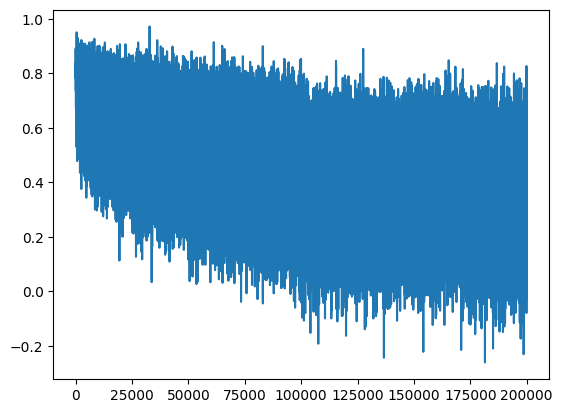

In [47]:
plt.plot(losses);

What do you think about the losses curve?
```
Comment here
```

Now, we can evaluate our model on `train` and `valid` dataset

In [48]:
check_loss("train")
check_loss("valid")

train: 1.4548
valid: 1.8679


Get the samples of model

In [49]:
# Get prediction
h_pre_act = X_samples @ W1 + b1
h = torch.tanh(h_pre_act)
logits = h @ W2 + b2
probs = F.softmax(logits, dim=1)
y_samples_pred = probs.argmax(axis=1)

y_samples_pred

tensor([6, 0, 5, 0, 0, 6, 8, 4, 2, 9, 1, 4, 3, 9, 5, 2, 7, 6, 8, 0, 8])

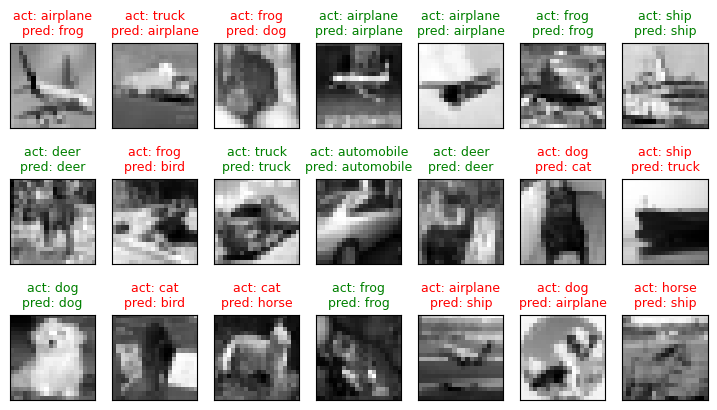

In [50]:
fig, axes = plt.subplots(ncols=7, nrows=3, figsize=(9, 5))
index = 0
for i in range(3):
    for j in range(7):
        act_label = labels[y_samples[index]]
        pred_label = labels[y_samples_pred[index]]
        if act_label==pred_label:
            color = 'g'
        else:
            color = 'r'
        axes[i,j].set_title(f'act: {act_label}\npred: {pred_label}', color=color, size=9)
        axes[i,j].imshow(X_samples[index].reshape((n_size, n_size)), cmap='gray')
        axes[i,j].get_xaxis().set_visible(False)
        axes[i,j].get_yaxis().set_visible(False)
        index += 1
plt.show()

## **Task 3: Fix the Saturated TanH**
---

- We need a non-zero loss gradient to keep the weights updating.
- Let's explore the loss gradient characteristics on the hidden layer neurons

In [51]:
# Initialize the MLP
g = torch.Generator().manual_seed(42)
W1 = torch.randn((n_img, n_hidden),   generator=g, dtype=torch.float64)
b1 = torch.randn(n_hidden,            generator=g, dtype=torch.float64)
W2 = torch.randn((n_hidden, n_class), generator=g, dtype=torch.float64) * 0.001
b2 = torch.randn(n_class,             generator=g, dtype=torch.float64) * 0

# Collect the parameters
parameters = [W1, b1, W2, b2]
print('Total parameters :', sum(p.nelement() for p in parameters))

# Activate the gradients
for p in parameters:
    p.requires_grad = True

Total parameters : 41110


In [52]:
# Initialize
max_steps = 200_000
batch_size = 32
losses = []

for i in range(max_steps):
    # First, construct the mini batch
    ix = torch.randint(low = 0,
                       high = X_train.shape[0],
                       size = (batch_size,),
                       generator = g)
    X_batch, y_batch = X_train[ix], y_train[ix]

    # Perform the forward pass
    h_pre_act = X_batch @ W1 + b1       # Hidden layer: pre-activated values
    h = torch.tanh(h_pre_act)           # Hidden layer: activated values with TanH
    logits = h @ W2 + b2                # Output layer: pre-activated values
    # Why logits not softmax of logits?

    # Calculate the loss
    loss = F.cross_entropy(input = logits,
                           target = y_batch)

    # Perform the backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # Update the parameters
    lr = 0.1 if i < 100_000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # Track
    if i % 10_000 == 0:
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")

    # Update progress in log
    losses.append(loss.log().item())
    break


      0/ 200000: 2.3002


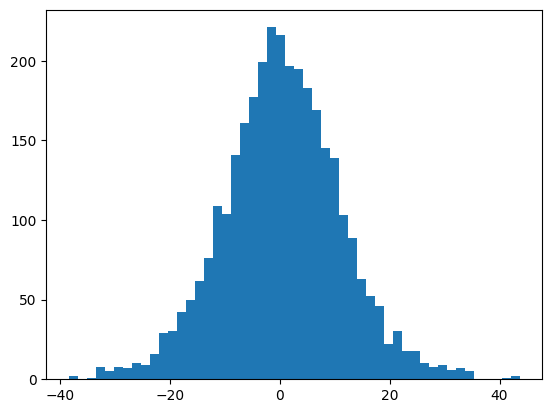

In [53]:
# Plot the histogram of h (output of the activated neurons)
plt.hist(h_pre_act.view(-1).tolist(), 50);

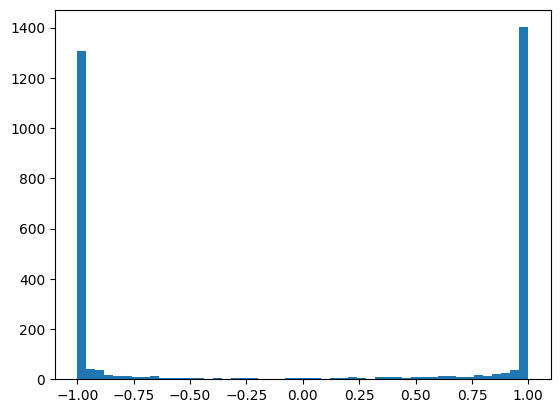

In [54]:
# Plot the histogram of h (output of the activated neurons)
plt.hist(h.view(-1).tolist(), 50);

- Based on the above histogram, can our neurons update the model weights?

- How active the `h` is to update the model weights?

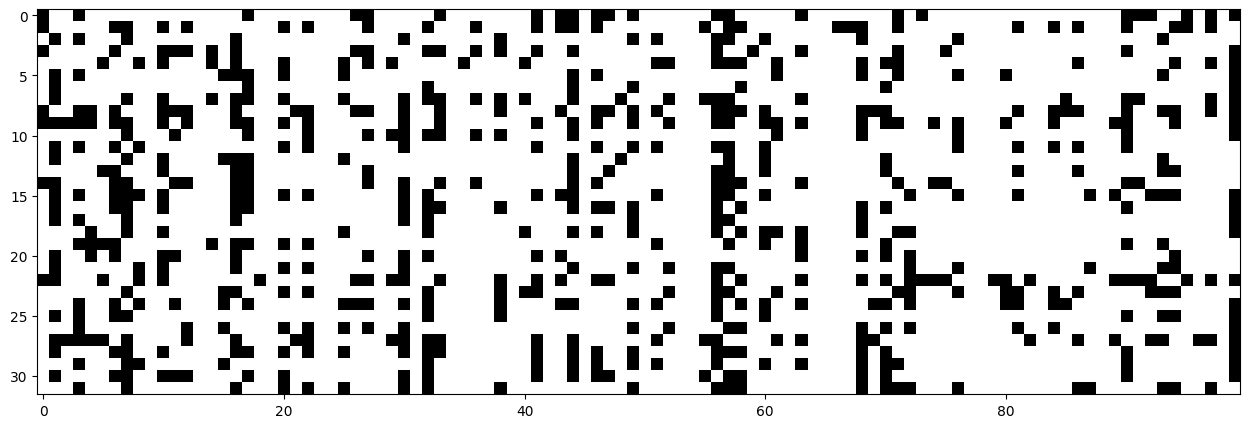

In [55]:
plt.figure(figsize=(20, 5))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')

- What is the problem with the above result?

- Now, let's fix that by limiting the dispersion of the `h_pre_act` values

In [56]:
# Initialize the MLP
g = torch.Generator().manual_seed(42)
W1 = torch.randn((n_img, n_hidden),   generator=g, dtype=torch.float64) * 0.1
b1 = torch.randn(n_hidden,            generator=g, dtype=torch.float64) * 0.1
W2 = torch.randn((n_hidden, n_class), generator=g, dtype=torch.float64) * 0.001
b2 = torch.randn(n_class,             generator=g, dtype=torch.float64) * 0

# Collect the parameters
parameters = [W1, b1, W2, b2]
print('Total parameters :', sum(p.nelement() for p in parameters))

# Activate the gradients
for p in parameters:
    p.requires_grad = True

Total parameters : 41110


In [57]:
# Initialize
max_steps = 200_000
batch_size = 32
losses = []

for i in range(max_steps):
    # First, construct the mini batch
    ix = torch.randint(low = 0,
                       high = X_train.shape[0],
                       size = (batch_size,),
                       generator = g)
    X_batch, y_batch = X_train[ix], y_train[ix]

    # Perform the forward pass
    h_pre_act = X_batch @ W1 + b1       # Hidden layer: pre-activated values
    h = torch.tanh(h_pre_act)           # Hidden layer: activated values with TanH
    logits = h @ W2 + b2                # Output layer: pre-activated values
    # Why logits not softmax of logits?

    # Calculate the loss
    loss = F.cross_entropy(input = logits,
                           target = y_batch)

    # Perform the backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # Update the parameters
    lr = 0.1 if i < 100_000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # Track
    if i % 10_000 == 0:
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")

    # Update progress in log
    losses.append(loss.log().item())
    break

      0/ 200000: 2.3018


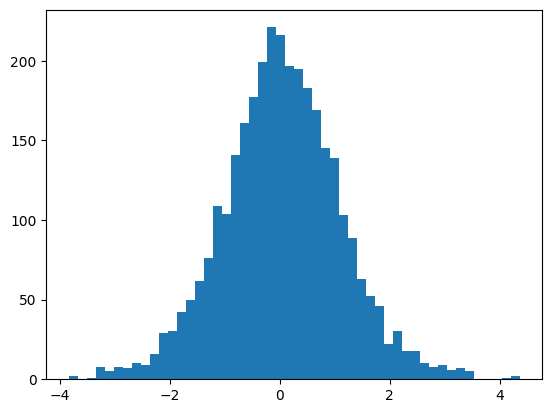

In [58]:
# Plot the histogram of h (output of the activated neurons)
plt.hist(h_pre_act.view(-1).tolist(), 50);

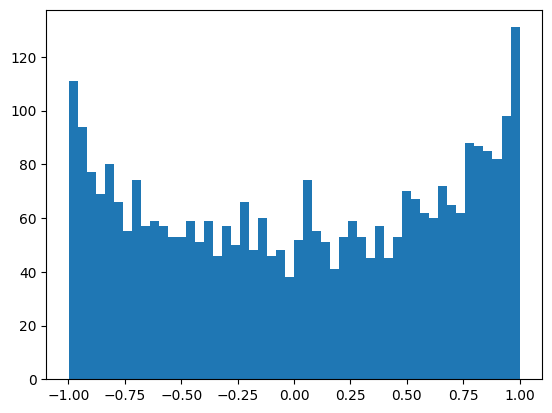

In [59]:
# Plot the histogram of h (output of the activated neurons)
plt.hist(h.view(-1).tolist(), 50);

- Based on the above histogram, can our neurons update the model weights?

- How active the `h` is to update the model weights?

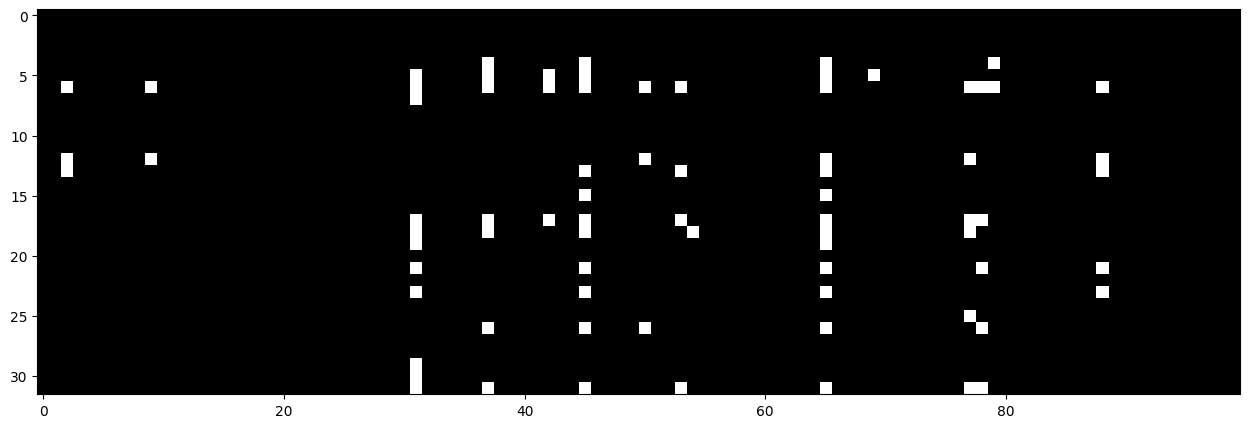

In [60]:
plt.figure(figsize=(20, 5))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')

- There is no dead neuron. We can start the training again

In [61]:
# Initialize the MLP
g = torch.Generator().manual_seed(42)
W1 = torch.randn((n_img, n_hidden),   generator=g, dtype=torch.float64) * 0.1
b1 = torch.randn(n_hidden,            generator=g, dtype=torch.float64) * 0.1
W2 = torch.randn((n_hidden, n_class), generator=g, dtype=torch.float64) * 0.001
b2 = torch.randn(n_class,             generator=g, dtype=torch.float64) * 0

# Collect the parameters
parameters = [W1, b1, W2, b2]
print('Total parameters :', sum(p.nelement() for p in parameters))

# Activate the gradients
for p in parameters:
    p.requires_grad = True

Total parameters : 41110


In [62]:
# Initialize
max_steps = 200_000
batch_size = 32
losses = []

for i in range(max_steps):
    # First, construct the mini batch
    ix = torch.randint(low = 0,
                       high = X_train.shape[0],
                       size = (batch_size,),
                       generator = g)
    X_batch, y_batch = X_train[ix], y_train[ix]

    # Perform the forward pass
    h_pre_act = X_batch @ W1 + b1       # Hidden layer: pre-activated values
    h = torch.tanh(h_pre_act)           # Hidden layer: activated values with TanH
    logits = h @ W2 + b2                # Output layer: pre-activated values
    # Why logits not softmax of logits?

    # Calculate the loss
    loss = F.cross_entropy(input = logits,
                           target = y_batch)

    # Perform the backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # Update the parameters
    lr = 0.1 if i < 100_000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # Track
    if i % 10_000 == 0:
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")

    # Update progress in log
    losses.append(loss.log().item())


      0/ 200000: 2.3018
  10000/ 200000: 2.1197
  20000/ 200000: 1.5142
  30000/ 200000: 1.4754
  40000/ 200000: 1.2601
  50000/ 200000: 1.3285
  60000/ 200000: 1.4431
  70000/ 200000: 1.2972
  80000/ 200000: 1.3663
  90000/ 200000: 1.0844
 100000/ 200000: 1.0281
 110000/ 200000: 1.4789
 120000/ 200000: 1.6807
 130000/ 200000: 1.1819
 140000/ 200000: 0.8080
 150000/ 200000: 1.4127
 160000/ 200000: 1.0182
 170000/ 200000: 1.3767
 180000/ 200000: 1.2469
 190000/ 200000: 1.1475


Now, let's plot the losses

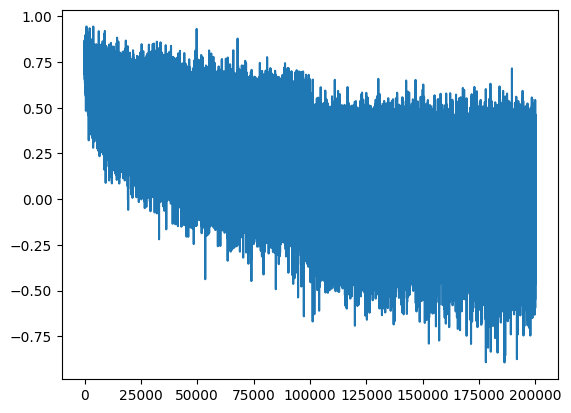

In [63]:
plt.plot(losses);

What do you think about the losses curve?
```
Comment here
```

Now, we can evaluate our model on `train` and `valid` dataset

In [64]:
check_loss("train")
check_loss("valid")

train: 1.0116
valid: 2.0491


Get the samples of model

In [65]:
# Get prediction
h_pre_act = X_samples @ W1 + b1
h = torch.tanh(h_pre_act)
logits = h @ W2 + b2
probs = F.softmax(logits, dim=1)
y_samples_pred = probs.argmax(axis=1)

y_samples_pred

tensor([0, 0, 5, 0, 0, 6, 8, 4, 8, 1, 1, 2, 3, 9, 5, 7, 5, 6, 7, 2, 4])

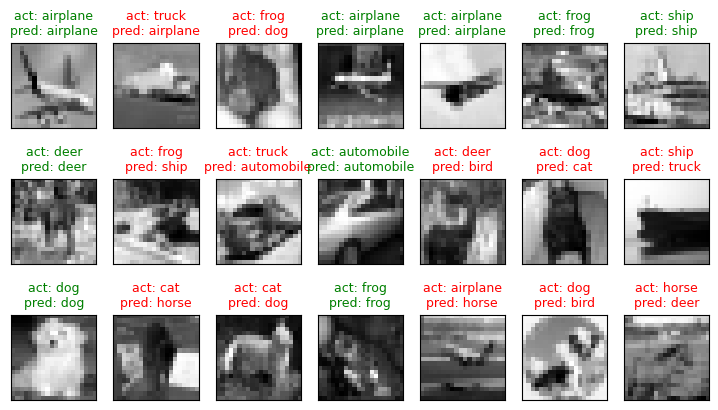

In [66]:
fig, axes = plt.subplots(ncols=7, nrows=3, figsize=(9, 5))
index = 0
for i in range(3):
    for j in range(7):
        act_label = labels[y_samples[index]]
        pred_label = labels[y_samples_pred[index]]
        if act_label==pred_label:
            color = 'g'
        else:
            color = 'r'
        axes[i,j].set_title(f'act: {act_label}\npred: {pred_label}', color=color, size=9)
        axes[i,j].imshow(X_samples[index].reshape((n_size, n_size)), cmap='gray')
        axes[i,j].get_xaxis().set_visible(False)
        axes[i,j].get_yaxis().set_visible(False)
        index += 1
plt.show()

## **Task 4: Input Initialization**
---

- Problem: Our input distribution might change, thus the distribution of `h_pre_act` might change also.
- Solution: Normalize the weight!

tensor(0.0004) tensor(0.9987)
tensor(0.0069) tensor(20.1568)


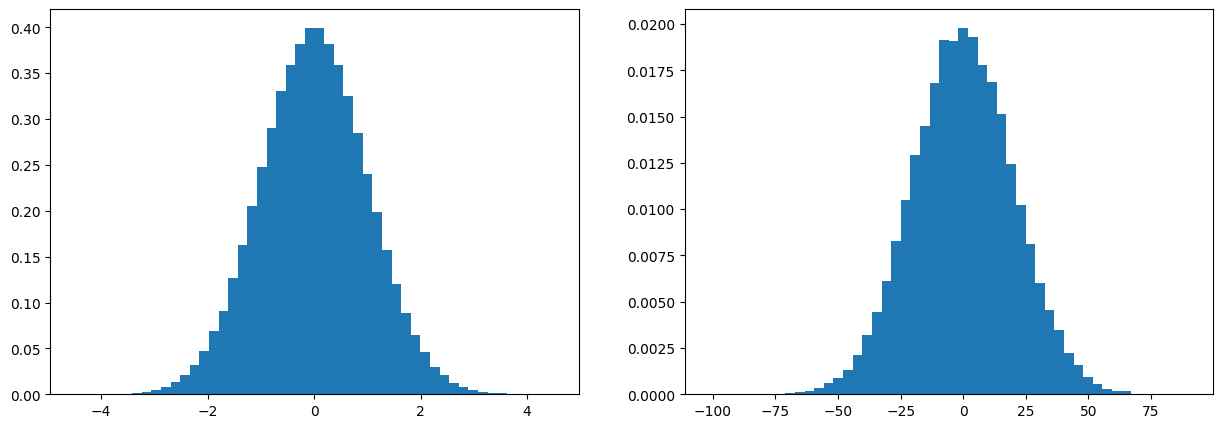

In [67]:
# Example of unnormalize weight
fan_in = 400     # input
x_ = torch.randn(1000, 400)
w_ = torch.randn(fan_in, 50)
y_ = x_ @ w_

print(x_.mean(), x_.std())
print(y_.mean(), y_.std())

plt.figure(figsize=(15, 5))
plt.subplot(121)
plt.hist(x_.view(-1).tolist(), 50, density=True);
plt.subplot(122)
plt.hist(y_.view(-1).tolist(), 50, density=True);

- Notice that the mean is similar but the standard deviation is larger.
- This will make our neurons dead later.
- We can normalize the weight to maintain the standard deviation.

tensor(0.0005) tensor(1.0004)
tensor(0.0061) tensor(1.6820)


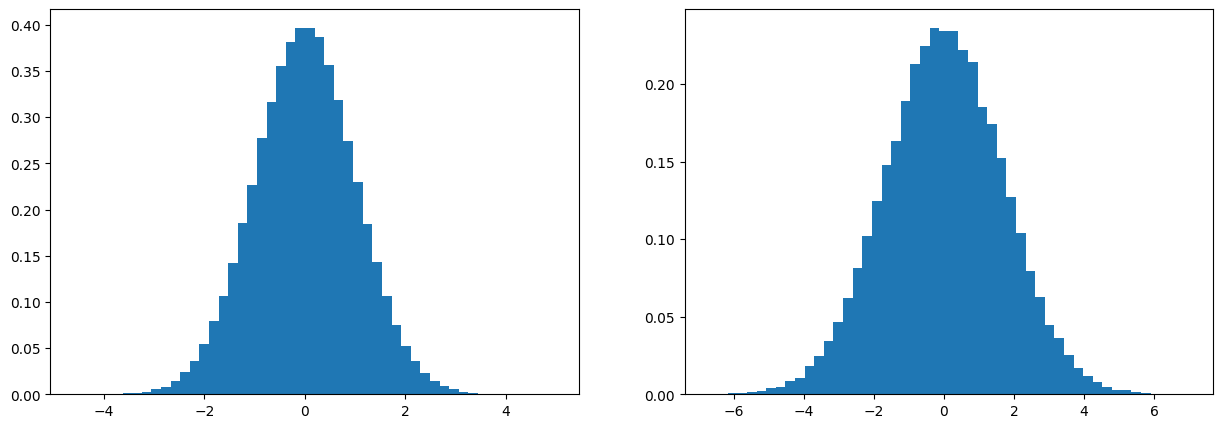

In [68]:
# Example of normalized weight using kaiming initialization
fan_in = 400     # input
x_ = torch.randn(1000, 400)
w_ = torch.randn(fan_in, 50) * (5/3) / (fan_in ** 0.5)
y_ = x_ @ w_

print(x_.mean(), x_.std())
print(y_.mean(), y_.std())

plt.figure(figsize=(15, 5))
plt.subplot(121)
plt.hist(x_.view(-1).tolist(), 50, density=True);
plt.subplot(122)
plt.hist(y_.view(-1).tolist(), 50, density=True);

Great! Now let's retrain again

In [69]:
# Parameters
gain = 5/3

# Initialize the MLP
g = torch.Generator().manual_seed(42)
W1 = torch.randn((n_img, n_hidden),   generator=g, dtype=torch.float64) * gain / (n_img**0.5)
b1 = torch.randn(n_hidden,            generator=g, dtype=torch.float64) * 0.1
W2 = torch.randn((n_hidden, n_class), generator=g, dtype=torch.float64) * 0.001
b2 = torch.randn(n_class,             generator=g, dtype=torch.float64) * 0

# Collect the parameters
parameters = [W1, b1, W2, b2]
print('Total parameters :', sum(p.nelement() for p in parameters))

# Activate the gradients
for p in parameters:
    p.requires_grad = True

Total parameters : 41110


In [70]:
# Initialize
max_steps = 200_000
batch_size = 32
losses = []

for i in range(max_steps):
    # First, construct the mini batch
    ix = torch.randint(low = 0,
                       high = X_train.shape[0],
                       size = (batch_size,),
                       generator = g)
    X_batch, y_batch = X_train[ix], y_train[ix]

    # Perform the forward pass
    h_pre_act = X_batch @ W1 + b1       # Hidden layer: pre-activated values
    h = torch.tanh(h_pre_act)           # Hidden layer: activated values with TanH
    logits = h @ W2 + b2                # Output layer: pre-activated values
    # Why logits not softmax of logits?

    # Calculate the loss
    loss = F.cross_entropy(input = logits,
                           target = y_batch)

    # Perform the backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # Update the parameters
    lr = 0.1 if i < 100_000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # Track
    if i % 10_000 == 0:
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")

    # Update progress in log
    losses.append(loss.log().item())
    break

      0/ 200000: 2.3019


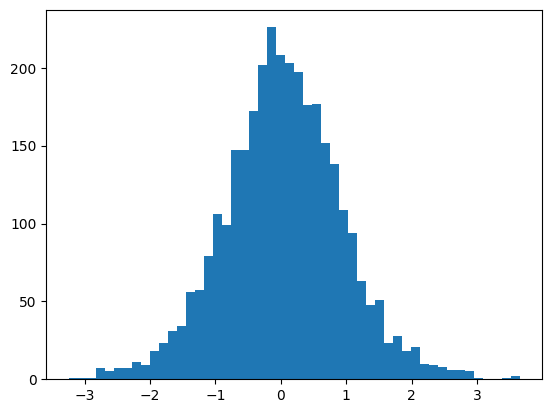

In [71]:
# Plot the histogram of h (output of the activated neurons)
plt.hist(h_pre_act.view(-1).tolist(), 50);

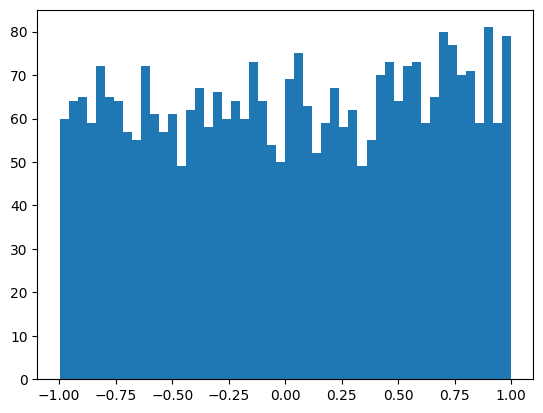

In [72]:
# Plot the histogram of h (output of the activated neurons)
plt.hist(h.view(-1).tolist(), 50);

- How active the `h` is to update the model weights?

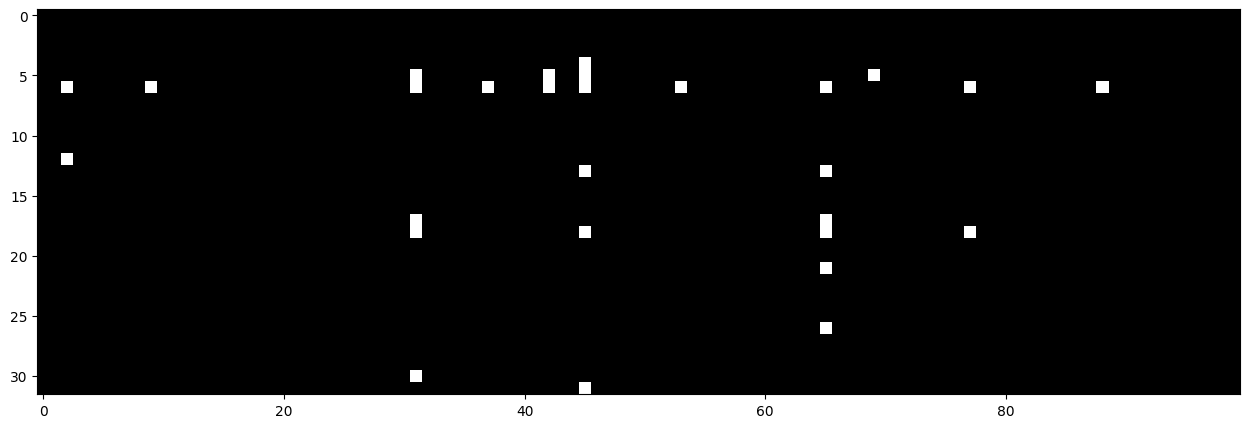

In [73]:
plt.figure(figsize=(20, 5))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')

In [74]:
# Parameters
gain = 5/3

# Initialize the MLP
g = torch.Generator().manual_seed(42)
W1 = torch.randn((n_img, n_hidden),   generator=g, dtype=torch.float64) * gain / (n_img**0.5)
b1 = torch.randn(n_hidden,            generator=g, dtype=torch.float64) * 0.1
W2 = torch.randn((n_hidden, n_class), generator=g, dtype=torch.float64) * 0.001
b2 = torch.randn(n_class,             generator=g, dtype=torch.float64) * 0

# Collect the parameters
parameters = [W1, b1, W2, b2]
print('Total parameters :', sum(p.nelement() for p in parameters))

# Activate the gradients
for p in parameters:
    p.requires_grad = True

Total parameters : 41110


In [75]:
# Initialize
max_steps = 200_000
batch_size = 32
losses = []

for i in range(max_steps):
    # First, construct the mini batch
    ix = torch.randint(low = 0,
                       high = X_train.shape[0],
                       size = (batch_size,),
                       generator = g)
    X_batch, y_batch = X_train[ix], y_train[ix]

    # Perform the forward pass
    h_pre_act = X_batch @ W1 + b1       # Hidden layer: pre-activated values
    h = torch.tanh(h_pre_act)           # Hidden layer: activated values with TanH
    logits = h @ W2 + b2                # Output layer: pre-activated values
    # Why logits not softmax of logits?

    # Calculate the loss
    loss = F.cross_entropy(input = logits,
                           target = y_batch)

    # Perform the backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # Update the parameters
    lr = 0.1 if i < 100_000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # Track
    if i % 10_000 == 0:
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")

    # Update progress in log
    losses.append(loss.log().item())


      0/ 200000: 2.3019
  10000/ 200000: 2.0764
  20000/ 200000: 1.4844
  30000/ 200000: 1.5588
  40000/ 200000: 1.4969
  50000/ 200000: 1.2341
  60000/ 200000: 1.6818
  70000/ 200000: 1.3794
  80000/ 200000: 1.3695
  90000/ 200000: 0.9862
 100000/ 200000: 1.0823
 110000/ 200000: 1.4190
 120000/ 200000: 1.5972
 130000/ 200000: 1.2961
 140000/ 200000: 0.8231
 150000/ 200000: 1.3013
 160000/ 200000: 1.0261
 170000/ 200000: 1.0756
 180000/ 200000: 1.2125
 190000/ 200000: 1.0482


Now, let's plot the losses

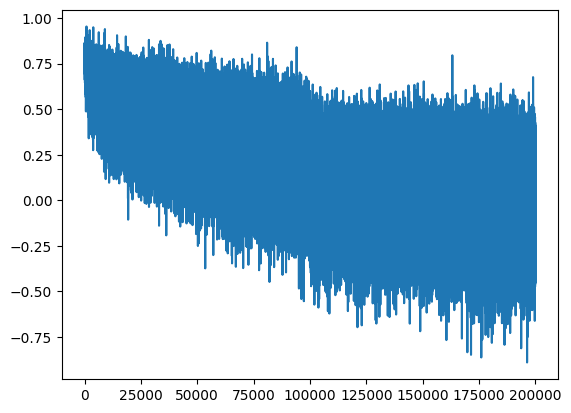

In [76]:
plt.plot(losses);

Now, we can evaluate our model on `train` and `valid` dataset

In [77]:
check_loss("train")
check_loss("valid")

train: 1.0218
valid: 2.0641


Get the samples of model

In [78]:
# Get prediction
h_pre_act = X_samples @ W1 + b1
h = torch.tanh(h_pre_act)
logits = h @ W2 + b2
probs = F.softmax(logits, dim=1)
y_samples_pred = probs.argmax(axis=1)

y_samples_pred

tensor([0, 0, 6, 0, 0, 4, 4, 4, 3, 1, 7, 2, 3, 8, 5, 7, 6, 6, 0, 4, 4])

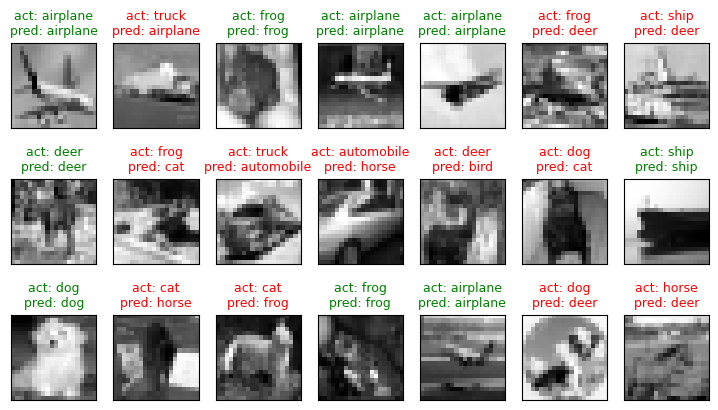

In [79]:
fig, axes = plt.subplots(ncols=7, nrows=3, figsize=(9, 5))
index = 0
for i in range(3):
    for j in range(7):
        act_label = labels[y_samples[index]]
        pred_label = labels[y_samples_pred[index]]
        if act_label==pred_label:
            color = 'g'
        else:
            color = 'r'
        axes[i,j].set_title(f'act: {act_label}\npred: {pred_label}', color=color, size=9)
        axes[i,j].imshow(X_samples[index].reshape((n_size, n_size)), cmap='gray')
        axes[i,j].get_xaxis().set_visible(False)
        axes[i,j].get_yaxis().set_visible(False)
        index += 1
plt.show()

## **Task 5: Batch Normalization**
---

- We do not want the `h_pre_act` to be near zero, because the `h` would not do anything
- We do not want the `h_pre_act` to be very high/low, because the `h` would be saturated
- We want it just on Gaussian.
- So, why don't we standardize the `h_pre_act` before activating it?
- Read more on : https://arxiv.org/abs/1502.03167  

In [80]:
# Parameters
gain = 5/3

# Initialize the MLP
g = torch.Generator().manual_seed(42)
W1 = torch.randn((n_img, n_hidden),   generator=g, dtype=torch.float64) * gain / (n_img**0.5)
b1 = torch.randn(n_hidden,            generator=g, dtype=torch.float64) * 0.1
W2 = torch.randn((n_hidden, n_class), generator=g, dtype=torch.float64) * 0.001
b2 = torch.randn(n_class,             generator=g, dtype=torch.float64) * 0

# Set the Batch Normalization Layer
bn_gain = torch.ones((1, n_hidden))
bn_bias = torch.zeros((1, n_hidden))

# Collect the parameters
parameters = [W1, b1, W2, b2, bn_gain, bn_bias]
print('Total parameters :', sum(p.nelement() for p in parameters))

# Activate the gradients
for p in parameters:
    p.requires_grad = True

Total parameters : 41310


- Normalize the pre-activation via Mini Batch Statistics on every iteration (not only at initialization)

In [81]:
# Initialize
max_steps = 200_000
batch_size = 32
losses = []

for i in range(max_steps):
    # First, construct the mini batch
    ix = torch.randint(low = 0,
                       high = X_train.shape[0],
                       size = (batch_size,),
                       generator = g)
    X_batch, y_batch = X_train[ix], y_train[ix]

    # Perform the forward pass
    h_pre_act = X_batch @ W1 + b1       # Hidden layer: pre-activated values
    h_pre_act = bn_gain * (h_pre_act - h_pre_act.mean(0, keepdim=True)) / h_pre_act.std(0, keepdim=True) + bn_bias
    h = torch.tanh(h_pre_act)           # Hidden layer: activated values with TanH
    logits = h @ W2 + b2                # Output layer: pre-activated values
    # Why logits not softmax of logits?

    # Calculate the loss
    loss = F.cross_entropy(input = logits,
                           target = y_batch)

    # Perform the backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # Update the parameters
    lr = 0.1 if i < 100_000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # Track
    if i % 10_000 == 0:
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")

    # Update progress in log
    losses.append(loss.log().item())


      0/ 200000: 2.3034
  10000/ 200000: 1.8161
  20000/ 200000: 1.4892
  30000/ 200000: 1.1665
  40000/ 200000: 0.9679
  50000/ 200000: 0.9989
  60000/ 200000: 1.1177
  70000/ 200000: 0.9348
  80000/ 200000: 1.0804
  90000/ 200000: 0.9959
 100000/ 200000: 0.7880
 110000/ 200000: 1.4704
 120000/ 200000: 1.0689
 130000/ 200000: 0.6868
 140000/ 200000: 0.7674
 150000/ 200000: 1.2690
 160000/ 200000: 0.6741
 170000/ 200000: 0.8407
 180000/ 200000: 0.7565
 190000/ 200000: 0.8064


Now, let's plot the losses

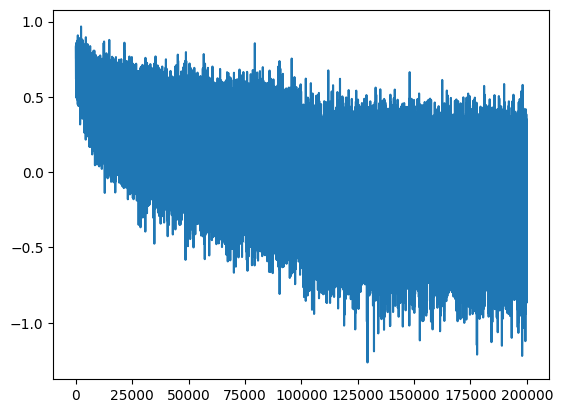

In [82]:
plt.plot(losses);

In [83]:
# Calibrate the batch norm at the end of training
with torch.no_grad():
    # Pass the training set through
    h_pre_act = X_train @ W1 + b1

    # measure the mean & std over the entire training set
    bn_mean = h_pre_act.mean(0, keepdim=True)
    bn_std = h_pre_act.std(0, keepdim=True)

In [84]:
@torch.no_grad()
def check_loss(type):
    """obtain loss on dataset"""
    X, y = {
        "train": (X_train, y_train),
        "valid": (X_valid, y_valid),
        "test": (X_test, y_test)
    }[type]

    # Perform the forward pass
    h_pre_act = X @ W1 + b1
    #h_pre_act = bn_gain * (h_pre_act - h_pre_act.mean(0, keepdim=True)) / h_pre_act.std(0, keepdim=True) + bn_bias
    h_pre_act = bn_gain * (h_pre_act - bn_mean) / bn_std + bn_bias
    h = torch.tanh(h_pre_act)
    logits = h @ W2 + b2

    # Calculate loss
    loss = F.cross_entropy(input = logits,
                           target = y)

    print(f"{type}: {loss.item():.4f}")

Now, we can evaluate our model on `train` and `valid` dataset

In [85]:
check_loss("train")
check_loss("valid")

train: 0.6332
valid: 2.4348


Get the samples of model

In [86]:
# Get prediction
h_pre_act = X_samples @ W1 + b1
h_pre_act = bn_gain * (h_pre_act - bn_mean) / bn_std + bn_bias
h = torch.tanh(h_pre_act)
logits = h @ W2 + b2
probs = F.softmax(logits, dim=1)
y_samples_pred = probs.argmax(axis=1)

y_samples_pred

tensor([5, 8, 6, 0, 0, 9, 8, 7, 6, 9, 1, 4, 6, 8, 5, 3, 3, 6, 7, 0, 1])

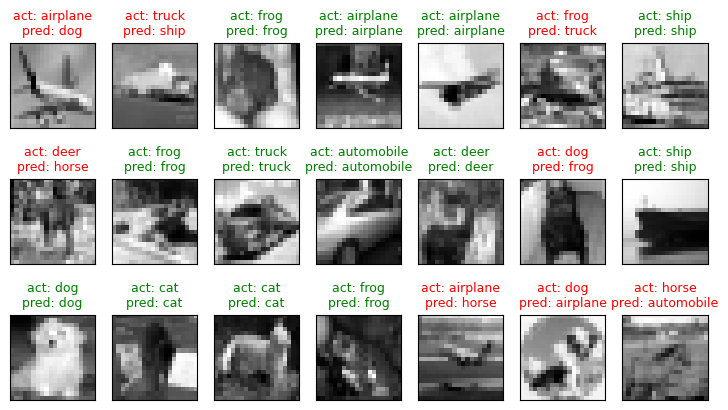

In [87]:
fig, axes = plt.subplots(ncols=7, nrows=3, figsize=(9, 5))
index = 0
for i in range(3):
    for j in range(7):
        act_label = labels[y_samples[index]]
        pred_label = labels[y_samples_pred[index]]
        if act_label==pred_label:
            color = 'g'
        else:
            color = 'r'
        axes[i,j].set_title(f'act: {act_label}\npred: {pred_label}', color=color, size=9)
        axes[i,j].imshow(X_samples[index].reshape((n_size, n_size)), cmap='gray')
        axes[i,j].get_xaxis().set_visible(False)
        axes[i,j].get_yaxis().set_visible(False)
        index += 1
plt.show()

- Great!
- If you want to predict (inferencing) during training

In [88]:
# Parameters
gain = 5/3

# Initialize the MLP
g = torch.Generator().manual_seed(42)
W1 = torch.randn((n_img, n_hidden),   generator=g, dtype=torch.float64) * gain / (n_img**0.5)
b1 = torch.randn(n_hidden,            generator=g, dtype=torch.float64) * 0.1
W2 = torch.randn((n_hidden, n_class), generator=g, dtype=torch.float64) * 0.001
b2 = torch.randn(n_class,             generator=g, dtype=torch.float64) * 0

# Set the Batch Normalization Layer
bn_gain = torch.ones((1, n_hidden))
bn_bias = torch.zeros((1, n_hidden))

# Set the running mean for inferencing
bn_mean_running = torch.zeros((1, n_hidden))
bn_std_running = torch.ones((1, n_hidden))

# Collect the parameters
parameters = [W1, b1, W2, b2, bn_gain, bn_bias]
print('Total parameters :', sum(p.nelement() for p in parameters))

# Activate the gradients
for p in parameters:
    p.requires_grad = True

Total parameters : 41310


Update the `check_loss` function

In [89]:
@torch.no_grad()
def check_loss(type, is_print=True):
    """obtain loss on dataset"""
    X, y = {
        "train": (X_train, y_train),
        "valid": (X_valid, y_valid),
        "test": (X_test, y_test)
    }[type]

    # Perform the forward pass
    h_pre_act = X @ W1 + b1
    h_pre_act = bn_gain * (h_pre_act - bn_mean_running) / bn_std_running + bn_bias
    h = torch.tanh(h_pre_act)
    logits = h @ W2 + b2

    # Calculate loss
    loss = F.cross_entropy(input = logits,
                           target = y)

    if is_print:
        print(f"{type}: {loss.item():.4f}")

    return loss


In [90]:
# Initialize
max_steps = 200_000
batch_size = 32
losses = []

for i in range(max_steps):
    # First, construct the mini batch
    ix = torch.randint(low = 0,
                       high = X_train.shape[0],
                       size = (batch_size,),
                       generator = g)
    X_batch, y_batch = X_train[ix], y_train[ix]

    # Perform the forward pass
    h_pre_act = X_batch @ W1 + b1       # Hidden layer: pre-activated values
    bn_mean_i = h_pre_act.mean(0, keepdim=True)
    bn_std_i = h_pre_act.std(0, keepdim=True)
    h_pre_act = bn_gain * (h_pre_act-bn_mean_i) / bn_std_i + bn_bias

    # Inferencing
    with torch.no_grad():
        bn_mean_running = 0.999 * bn_mean_running + 0.001 * bn_mean_i
        bn_std_running = 0.999 * bn_std_running + 0.001 * bn_std_i

    h = torch.tanh(h_pre_act)           # Hidden layer: activated values with TanH
    logits = h @ W2 + b2                # Output layer: pre-activated values
    # Why logits not softmax of logits?

    # Calculate the loss
    loss = F.cross_entropy(input = logits,
                           target = y_batch)

    # Perform the backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # Update the parameters
    lr = 0.1 if i < 100_000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # Track
    if i % 10_000 == 0:
        loss_train = check_loss('train', False)
        loss_valid = check_loss('valid', False)
        print(f"{i:7d}/{max_steps:7d} | loss: {loss.item():.4f} | loss_train: {loss_train.item():.4f} | loss_valid: {loss_valid.item():.4f}")

    # Update progress in log
    losses.append(loss.log().item())


      0/ 200000 | loss: 2.3034 | loss_train: 2.2983 | loss_valid: 2.3000
  10000/ 200000 | loss: 1.8161 | loss_train: 1.9592 | loss_valid: 2.1607
  20000/ 200000 | loss: 1.4892 | loss_train: 1.7397 | loss_valid: 2.1080
  30000/ 200000 | loss: 1.1665 | loss_train: 1.5710 | loss_valid: 2.1158
  40000/ 200000 | loss: 0.9679 | loss_train: 1.7496 | loss_valid: 2.3850
  50000/ 200000 | loss: 0.9989 | loss_train: 1.4130 | loss_valid: 2.1845
  60000/ 200000 | loss: 1.1177 | loss_train: 1.4694 | loss_valid: 2.4130
  70000/ 200000 | loss: 0.9348 | loss_train: 1.5096 | loss_valid: 2.5203
  80000/ 200000 | loss: 1.0804 | loss_train: 1.4899 | loss_valid: 2.5246
  90000/ 200000 | loss: 0.9959 | loss_train: 1.4871 | loss_valid: 2.5706
 100000/ 200000 | loss: 0.7880 | loss_train: 1.7397 | loss_valid: 2.9368
 110000/ 200000 | loss: 1.4704 | loss_train: 0.7501 | loss_valid: 2.2173
 120000/ 200000 | loss: 1.0689 | loss_train: 0.7398 | loss_valid: 2.2686
 130000/ 200000 | loss: 0.6868 | loss_train: 0.7249

Now, we can evaluate our model on `train` and `valid` dataset

In [91]:
loss_train = check_loss("train", False)
loss_valid = check_loss("valid", False)

print(f'train: {loss_train.item():.4f}')
print(f'valid: {loss_valid.item():.4f}')

train: 0.6801
valid: 2.4735


Get the samples of model

In [92]:
# Get prediction
h_pre_act = X_samples @ W1 + b1
h_pre_act = bn_gain * (h_pre_act - bn_mean_running) / bn_std_running + bn_bias
h = torch.tanh(h_pre_act)
logits = h @ W2 + b2
probs = F.softmax(logits, dim=1)
y_samples_pred = probs.argmax(axis=1)

y_samples_pred

tensor([5, 8, 6, 4, 0, 9, 8, 4, 6, 9, 1, 2, 6, 1, 5, 3, 3, 6, 7, 0, 1])

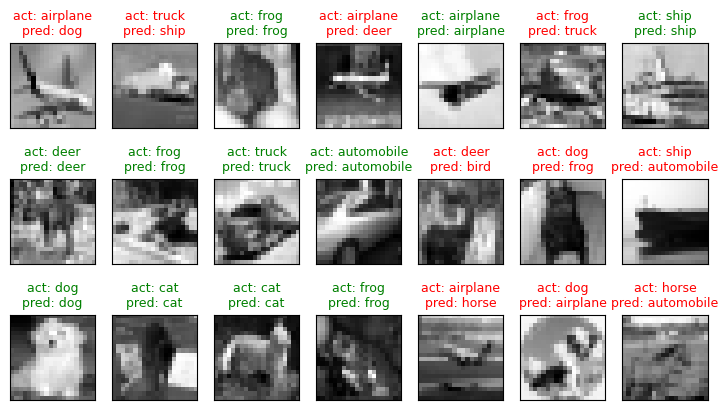

In [93]:
fig, axes = plt.subplots(ncols=7, nrows=3, figsize=(9, 5))
index = 0
for i in range(3):
    for j in range(7):
        act_label = labels[y_samples[index]]
        pred_label = labels[y_samples_pred[index]]
        if act_label==pred_label:
            color = 'g'
        else:
            color = 'r'
        axes[i,j].set_title(f'act: {act_label}\npred: {pred_label}', color=color, size=9)
        axes[i,j].imshow(X_samples[index].reshape((n_size, n_size)), cmap='gray')
        axes[i,j].get_xaxis().set_visible(False)
        axes[i,j].get_yaxis().set_visible(False)
        index += 1
plt.show()

## **Task 6: Make the code better**
---

First, we initialize the dataset

In [94]:
from torch.utils.data import Dataset
from torch.utils.data.dataloader import DataLoader

In [95]:
# Create the Dataset
class CIFAR10Dataset(Dataset):
    """Return the dataset of CIFAR10"""
    def __init__(self, data):
        """record the data"""
        self.data = data

    def __getitem__(self, idx):
        """Get X and y data from an index"""
        y = self.data[idx][0]
        X = self.data[idx][1:]
        return X, y

    def __len__(self):
        """return the data length"""
        return len(self.data)

def read_data(fname):
    """Read the data"""
    # Read data
    raw_data = pd.read_csv(fname)

    # Wrangle data
    y = raw_data['0'].to_numpy().astype('int64')
    X = raw_data.drop(columns=['0'], axis=1).to_numpy().astype('float64')

    # Validate
    print('Input shape  :', X.shape)
    print('Target shape :', y.shape)

    return X, y

def create_datasets(input_file):
    """Load and create the dataset"""
    # Read data
    X, y = read_data(input_file)

    # Concat file
    X = torch.tensor(X)
    y = torch.tensor(y)
    data = torch.column_stack((y, X))

    # Perform splitting
    # Splitting into train, valid, and test
    # For valid & test, minimum 1000 or 10% of all data
    rp = torch.randperm(len(data)).tolist()

    # 1st split --> all to train & valid
    # 2nd split --> valid to valid & test
    valid_size = min(2000, int(0.1 * len(data)))
    test_size = min(1000, int(0.1 * valid_size))

    # Split
    train_data = [data[i] for i in rp[:-valid_size]]
    valid_data = [data[i] for i in rp[-valid_size:-test_size]]
    test_data = [data[i] for i in rp[-test_size:]]

    # Wrap in dataset objects
    train_dataset = CIFAR10Dataset(train_data)
    valid_dataset = CIFAR10Dataset(valid_data)
    test_dataset = CIFAR10Dataset(test_data)

    # Validate
    print('Train shape :', len(train_dataset))
    print('Valid shape :', len(valid_dataset))
    print('Test shape  :', len(test_dataset))

    return train_dataset, valid_dataset, test_dataset


In [96]:
# Initialize datasets
train_dataset, valid_dataset, test_dataset = create_datasets('CIFAR10_grey_ds.csv')

Input shape  : (30000, 400)
Target shape : (30000,)
Train shape : 28000
Valid shape : 1800
Test shape  : 200


Then, we initialize the model

In [97]:
import time
import torch.nn as nn

from dataclasses import dataclass

In [98]:
@dataclass
class ModelConfig:
    n_img: int = 400
    n_hidden: int = 100
    n_class: int = 10

In [99]:
# Create the MLP class
class MLP(nn.Module):
    """MLP without batch normalization"""
    def __init__(self, config):
        super().__init__()

        # Extract the config
        self.n_img = config.n_img
        self.n_hidden = config.n_hidden
        self.n_class = config.n_class

        # Create the MLP
        torch.manual_seed(42)
        self.mlp = nn.Sequential(
            nn.Linear(in_features=self.n_img, out_features=self.n_hidden, bias=True, dtype=torch.float64),
            nn.Tanh(),
            nn.Linear(in_features=self.n_hidden, out_features=self.n_class, dtype=torch.float64)
        )

    def forward(self, img):
        logits = self.mlp(img)
        return logits

class MLPB(nn.Module):
    """MLP with Batch Normalization"""
    def __init__(self, config):
        super().__init__()

        # Extract the config
        self.n_img = config.n_img
        self.n_hidden = config.n_hidden
        self.n_class = config.n_class

        # Create the MLP
        torch.manual_seed(42)
        self.mlp = nn.Sequential(
            nn.Linear(in_features=self.n_img, out_features=self.n_hidden, bias=True, dtype=torch.float64),
            nn.BatchNorm1d(num_features=self.n_hidden, dtype=torch.float64),
            nn.Tanh(),
            nn.Linear(in_features=self.n_hidden, out_features=self.n_class, dtype=torch.float64)
        )

    def forward(self, img):
        logits = self.mlp(img)
        return logits

# Print number of parameters
def count_parameters(model):
    print('Total parameters :', sum(p.nelement() for p in model.parameters()))


In [100]:
# Initialize model
config = ModelConfig()

# Create model
model_mlp = MLP(config)     # Model MLP without Batch Normalization
model_mlpb = MLPB(config)   # Model MLP with Batch Normalization

# Check the number of parameters
count_parameters(model_mlp)
count_parameters(model_mlpb)

Total parameters : 41110
Total parameters : 41310


Next, we create the training function & evaluation function

In [101]:
import time

In [102]:
# Generate infinite data loader for training
class InfiniteDataLoader:
    """
    Adapting Makemore - Andrej Karpathy
    """
    def __init__(self, dataset, **kwargs):
        train_sampler = torch.utils.data.RandomSampler(dataset, replacement=True, num_samples=int(1e10))
        self.train_loader = DataLoader(dataset, sampler=train_sampler, **kwargs)
        self.data_iter = iter(self.train_loader)

    def next(self):
        try:
            batch = next(self.data_iter)
        except StopIteration:
            self.data_iter = iter(self.train_loader)
            batch = next(self.data_iter)

        return batch


In [103]:
# Create evaluation function
def get_accuracy(model, type, is_print=False):
    """get the accuracy of model"""
    # Prepare the data
    data = {
        'train': train_dataset,
        'valid': valid_dataset,
        'test': test_dataset
    }[type]

    # Set the data loader
    data = torch.utils.data.DataLoader(data,
                                       batch_size=len(data))

    # Use torch.no_grad()
    model.eval()
    for X, y in data:
        # Perform feedforward
        logits = model(X)

        # Calculate the accuracy
        pred = logits.max(axis=1)[1]
        n_correct = (pred == y).sum().item()
        n_tot = len(y)
        acc = n_correct/n_tot

        # If is_print
        if is_print:
            loss = F.cross_entropy(input = logits,
                                   target = y.type(torch.int64))
            print(f'{type}: {loss:.4f}')

    return acc


In [104]:
def train(model, train_dataset, batch_size=32, learning_rate=0.1, num_epochs=200_000):
    """Train the model"""
    # Set random seed
    g = torch.Generator().manual_seed(42)

    # Set the optimizer
    optimizer = torch.optim.SGD(params = model.parameters(),
                                lr=learning_rate)

    # Set batch loader
    batch_loader = InfiniteDataLoader(train_dataset,
                                      batch_size=batch_size)

    # Track learning curve
    losses = []

    # Training
    for epoch in range(num_epochs):
        t0 = time.time()

        # First, construct the mini batch
        batch = batch_loader.next()
        X_batch, y_batch = batch
        y_batch = y_batch.type(torch.int64)

        # Forward pass & loss
        model.train()       # Set the torch grad
        logits = model(X_batch)
        loss = F.cross_entropy(input = logits,
                               target = y_batch)

        # Get gradient
        model.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()

        t1 = time.time()

        # Track
        if epoch % 10_000 == 0:
            train_acc = get_accuracy(model, 'train')
            valid_acc = get_accuracy(model, 'valid')
            print(f"step: {epoch:7d}/{num_epochs:7d} | Loss: {loss.item():.4f} | Train Acc: {train_acc:.4f} | Valid Acc: {valid_acc:.4f} | step time: {(t1-t0)*1000:.2f}ms")

        # Save the current training information
        losses.append(loss.log().item())

    return losses


Train the MLP without Batch Normalization layer

In [105]:
losses_mlp = train(model_mlp, train_dataset, learning_rate = 0.1)

step:       0/ 200000 | Loss: 2.2708 | Train Acc: 0.1214 | Valid Acc: 0.1222 | step time: 9.23ms
step:   10000/ 200000 | Loss: 1.9514 | Train Acc: 0.4005 | Valid Acc: 0.3678 | step time: 0.88ms
step:   20000/ 200000 | Loss: 1.3623 | Train Acc: 0.4281 | Valid Acc: 0.3733 | step time: 0.91ms
step:   30000/ 200000 | Loss: 1.4468 | Train Acc: 0.4360 | Valid Acc: 0.3694 | step time: 0.93ms
step:   40000/ 200000 | Loss: 1.2962 | Train Acc: 0.4598 | Valid Acc: 0.3844 | step time: 0.92ms
step:   50000/ 200000 | Loss: 1.3776 | Train Acc: 0.4894 | Valid Acc: 0.3956 | step time: 0.89ms
step:   60000/ 200000 | Loss: 1.4863 | Train Acc: 0.4884 | Valid Acc: 0.3850 | step time: 0.89ms
step:   70000/ 200000 | Loss: 1.4469 | Train Acc: 0.5022 | Valid Acc: 0.3806 | step time: 0.89ms
step:   80000/ 200000 | Loss: 1.1490 | Train Acc: 0.5172 | Valid Acc: 0.3806 | step time: 0.88ms
step:   90000/ 200000 | Loss: 1.1937 | Train Acc: 0.5282 | Valid Acc: 0.3783 | step time: 0.93ms
step:  100000/ 200000 | Loss: 

Now, let's plot the losses

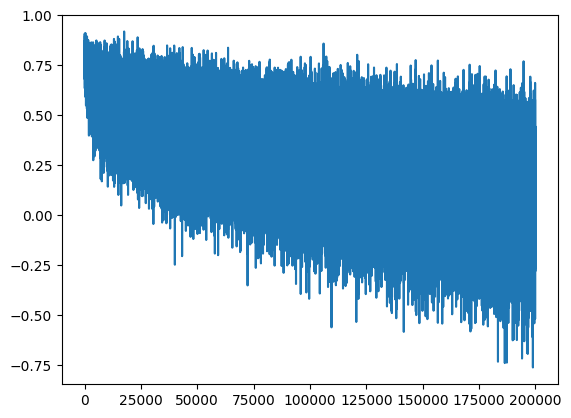

In [106]:
plt.plot(losses_mlp);

Now, we can evaluate our model on `train` and `valid` dataset

In [107]:
train_acc = get_accuracy(model_mlp, 'train', is_print=True)
valid_acc = get_accuracy(model_mlp, 'valid', is_print=True)

print('train acc:', train_acc)
print('valid acc:', valid_acc)

train: 1.0931
valid: 2.1613
train acc: 0.6184642857142857
valid acc: 0.3838888888888889


Get the samples of model

In [108]:
# Get prediction
model_mlp.eval()
probs_sample = model_mlp(X_samples)
y_samples_pred = probs_sample.max(1, keepdim=True)[1].view(-1)

y_samples_pred

tensor([0, 0, 4, 6, 0, 4, 8, 4, 6, 1, 1, 4, 5, 8, 5, 2, 3, 6, 4, 5, 7])

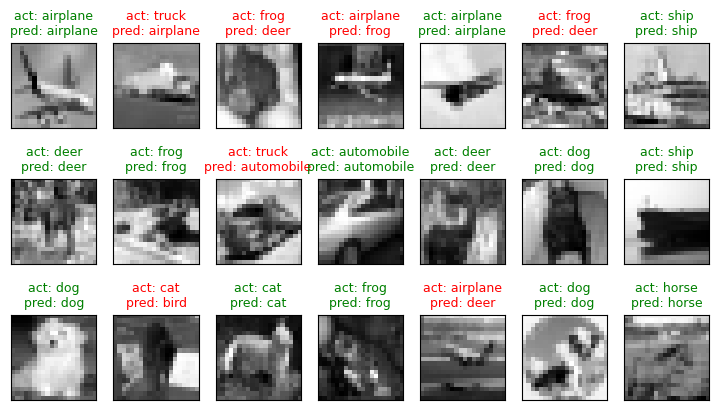

In [109]:
fig, axes = plt.subplots(ncols=7, nrows=3, figsize=(9, 5))
index = 0
for i in range(3):
    for j in range(7):
        act_label = labels[y_samples[index]]
        pred_label = labels[y_samples_pred[index]]
        if act_label==pred_label:
            color = 'g'
        else:
            color = 'r'
        axes[i,j].set_title(f'act: {act_label}\npred: {pred_label}', color=color, size=9)
        axes[i,j].imshow(X_samples[index].reshape((n_size, n_size)), cmap='gray')
        axes[i,j].get_xaxis().set_visible(False)
        axes[i,j].get_yaxis().set_visible(False)
        index += 1
plt.show()

Train the MLP with Batch Normalization layer

In [110]:
losses_mlpb = train(model_mlpb, train_dataset, learning_rate = 0.1)

step:       0/ 200000 | Loss: 2.3755 | Train Acc: 0.1097 | Valid Acc: 0.1278 | step time: 11.97ms
step:   10000/ 200000 | Loss: 1.5552 | Train Acc: 0.3804 | Valid Acc: 0.3467 | step time: 1.03ms
step:   20000/ 200000 | Loss: 1.3919 | Train Acc: 0.5028 | Valid Acc: 0.3867 | step time: 1.04ms
step:   30000/ 200000 | Loss: 1.4930 | Train Acc: 0.5070 | Valid Acc: 0.3900 | step time: 1.14ms
step:   40000/ 200000 | Loss: 0.9625 | Train Acc: 0.5496 | Valid Acc: 0.3617 | step time: 1.04ms
step:   50000/ 200000 | Loss: 1.3009 | Train Acc: 0.5062 | Valid Acc: 0.3428 | step time: 1.05ms
step:   60000/ 200000 | Loss: 1.1115 | Train Acc: 0.5508 | Valid Acc: 0.3567 | step time: 1.06ms
step:   70000/ 200000 | Loss: 0.8026 | Train Acc: 0.6174 | Valid Acc: 0.3756 | step time: 1.03ms
step:   80000/ 200000 | Loss: 1.1048 | Train Acc: 0.6172 | Valid Acc: 0.3533 | step time: 1.07ms
step:   90000/ 200000 | Loss: 1.2278 | Train Acc: 0.6401 | Valid Acc: 0.3606 | step time: 1.04ms
step:  100000/ 200000 | Loss:

Now, let's plot the losses

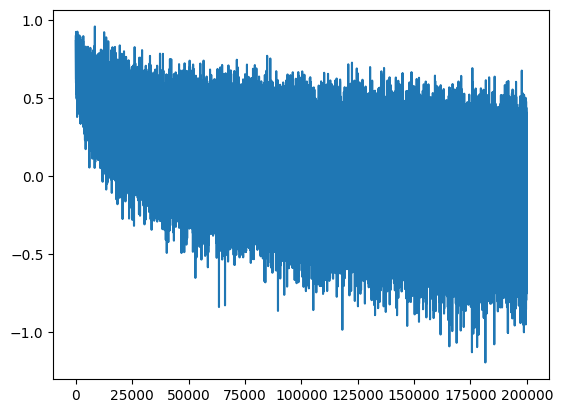

In [111]:
plt.plot(losses_mlpb);

Now, we can evaluate our model on `train` and `valid` dataset

In [112]:
train_acc = get_accuracy(model_mlpb, 'train', is_print=True)
valid_acc = get_accuracy(model_mlpb, 'valid', is_print=True)

print('train acc:', train_acc)
print('valid acc:', valid_acc)

train: 0.9533
valid: 2.6393
train acc: 0.66625
valid acc: 0.33444444444444443


Get the samples of model

In [113]:
# Get prediction
model_mlpb.eval()
probs_sample = model_mlpb(X_samples)
y_samples_pred = probs_sample.max(1, keepdim=True)[1].view(-1)

y_samples_pred

tensor([3, 9, 3, 4, 0, 6, 8, 4, 6, 9, 1, 4, 5, 7, 5, 3, 3, 6, 0, 3, 7])

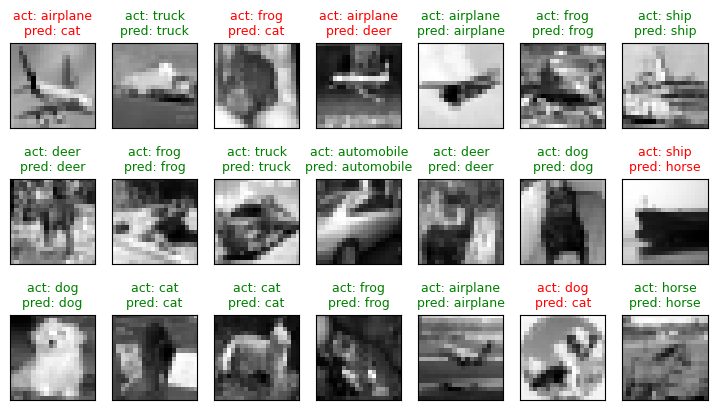

In [114]:
fig, axes = plt.subplots(ncols=7, nrows=3, figsize=(9, 5))
index = 0
for i in range(3):
    for j in range(7):
        act_label = labels[y_samples[index]]
        pred_label = labels[y_samples_pred[index]]
        if act_label==pred_label:
            color = 'g'
        else:
            color = 'r'
        axes[i,j].set_title(f'act: {act_label}\npred: {pred_label}', color=color, size=9)
        axes[i,j].imshow(X_samples[index].reshape((n_size, n_size)), cmap='gray')
        axes[i,j].get_xaxis().set_visible(False)
        axes[i,j].get_yaxis().set_visible(False)
        index += 1
plt.show()

Best model --> model MLP **without** Batch Normalization Layer (with highest validation accuracy)

In [115]:
# Test on test set
# Get random index from test data
ix = torch.randint(low = 0,
                   high = X_test.shape[0],
                   size = (21,),
                   generator = torch.Generator().manual_seed(123))

X_test_samples, y_test_samples = X_test[ix], y_test[ix]
y_test_samples

tensor([1, 0, 7, 2, 9, 3, 1, 0, 1, 4, 8, 2, 2, 2, 1, 5, 5, 6, 2, 5, 1])

In [116]:
# Get prediction
model_mlp.eval()
probs_sample = model_mlp(X_test_samples)
y_test_samples_pred = probs_sample.max(1, keepdim=True)[1].view(-1)

y_test_samples_pred

tensor([1, 3, 7, 2, 4, 0, 1, 0, 8, 5, 9, 0, 5, 0, 1, 3, 5, 6, 5, 3, 6])

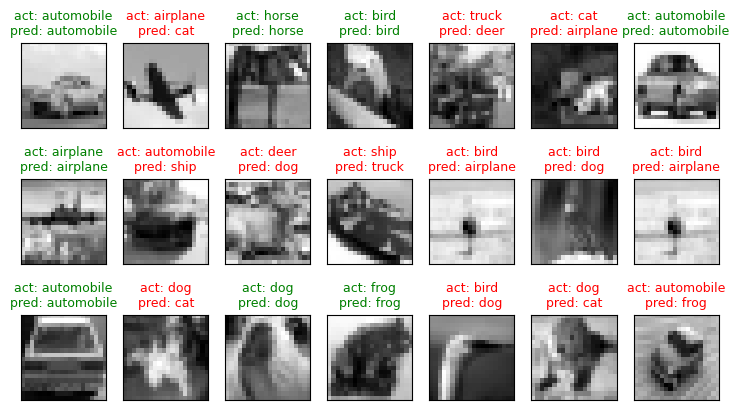

In [117]:
fig, axes = plt.subplots(ncols=7, nrows=3, figsize=(9, 5))
index = 0
for i in range(3):
    for j in range(7):
        act_label = labels[y_test_samples[index]]
        pred_label = labels[y_test_samples_pred[index]]
        if act_label==pred_label:
            color = 'g'
        else:
            color = 'r'
        axes[i,j].set_title(f'act: {act_label}\npred: {pred_label}', color=color, size=9)
        axes[i,j].imshow(X_test_samples[index].reshape((n_size, n_size)), cmap='gray')
        axes[i,j].get_xaxis().set_visible(False)
        axes[i,j].get_yaxis().set_visible(False)
        index += 1
plt.show()

In [118]:
train_acc = get_accuracy(model_mlp, 'train', is_print=True)
valid_acc = get_accuracy(model_mlp, 'valid', is_print=True)
test_acc = get_accuracy(model_mlp, 'test', is_print=True)

print('train acc:', train_acc)
print('valid acc:', valid_acc)
print('test acc:', test_acc)

train: 1.0931
valid: 2.1613
test: 2.4880
train acc: 0.6184642857142857
valid acc: 0.3838888888888889
test acc: 0.35
